# Edge Classifier Debug

**Goal**: Test the weighting and hard cut config of the data loading process

In [1]:
%load_ext autoreload
%autoreload 2

import os
import yaml

import numpy as np
import pandas as pd
import seaborn as sns
import yaml
import torch
import matplotlib.pyplot as plt
from time import time as tt
from torch_geometric.data import Data, HeteroData
import torchmetrics

## GNN Debug

In [2]:
from gnn4itk_cf.stages.edge_classifier.models.interaction_gnn import InteractionGNN

/opt/conda/envs/gnn4itk/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/gnn4itk/lib/python3.9/site-packages/cudf/utils/_numba.py:110: UserWarning: Using CUDA toolkit version (12, 2) with CUDA driver version (12, 0) requires minor version compatibility, which is not yet supported for CUDA driver versions 12.0 and above. It is likely that many cuDF operations will not work in this state. Please install CUDA toolkit version (12, 0) to continue using cuDF.
  warnings.warn(


In [3]:
model.hparams

NameError: name 'model' is not defined

In [5]:
config = yaml.load(open("../../examples/Example_1/gnn_train.yaml"), Loader=yaml.FullLoader)
model = InteractionGNN(config)
model.setup('fit')
model.hparams

/global/homes/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [particle_id] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/homes/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [nhits] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/homes/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [primary] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/homes/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [pdgId] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/homes/a/alazar/acorn/gnn4itk_cf/utils/loading_utils.py:78: UserWarning: OPTIONAL feature [ghost] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/homes/a/alazar/acorn/gnn4itk_cf/ut

Defining figures of merit


/global/homes/a/alazar/acorn/gnn4itk_cf/stages/edge_classifier/edge_classifier_stage.py:94: UserWarning: Failed to define figures of merit, due to logger unavailable
  warnings.warn(


"aggregation":        ['sum', 'mean', 'max', 'std']
"batchnorm":          False
"data_split":         [80, 10, 10]
"debug":              False
"edge_cut":           0.5
"edge_net_recurrent": True
"emb_channels":       0
"factor":             0.9
"gpus":               1
"hard_cuts":          {'pt': [1000, inf]}
"hidden":             128
"hidden_activation":  SiLU
"input_dir":          /scratch/cf/Example_1/module_map/
"layernorm":          True
"lr":                 0.001
"max_epochs":         100
"model":              InteractionGNN
"n_graph_iters":      8
"nb_edge_layer":      2
"nb_node_layer":      2
"node_features":      ['r', 'phi', 'z']
"node_net_recurrent": True
"node_scales":        [1000, 3.14, 1000]
"nodes":              1
"num_workers":        [8, 8, 8]
"output_activation":  Tanh
"patience":           10
"project":            CF_Example_1_GNN
"stage":              edge_classifier
"stage_dir":          /scratch/cf/Example_1/gnn/
"undirected":         True
"warmup":           

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = model.configure_optimizers()[0][0]
scheduler = model.configure_optimizers()[1][0]
print(device)

cuda


In [7]:
optimizer.param_groups[0]["lr"]

0.001

In [8]:
num_epochs=50
start = tt()
for epoch in range(num_epochs):
    train_acc = torchmetrics.Accuracy(task="binary").to(device)

    model.train()
    
    for batch_idx, data in enumerate(model.trainset):
        model.train()

        data = data.to(device)  # Move the batch of graph data to the device

        ### FORWARD AND BACK PROP
        logits = model(data)
        #target_labels = data.y.type(torch.float)
        #loss = F.mse_loss(logits, target_labels)  # Assuming 'y' contains the target labels
        loss = model.loss_function(logits, data)    
        
        if (model.hparams["warmup"] is not None) and (epoch < model.hparams["warmup"]):
            lr_scale = min(1.0, float(epoch + 1) / model.hparams["warmup"])
            for pg in optimizer.param_groups:
                pg["lr"] = lr_scale * model.hparams["lr"]
                print(pg["lr"])

        # update params

        optimizer.zero_grad()
        loss.backward()
        optimizer.step(closure=None)
        
        ### LOGGING
        #if not batch_idx % 300:
        print(f"Epoch: {epoch+1:04d}/{num_epochs:04d} | Batch {batch_idx:04d}/{len(model.trainset):04d} | Loss: {loss:.4f}")

        model.eval()
        with torch.no_grad():
            train_acc.update(logits, data.y.int())

    ### MORE LOGGING
    model.eval()
    with torch.no_grad():
        val_acc = torchmetrics.Accuracy(task="binary").to(device)

        for data in model.valset:
            data = data.to(device)  # Move the batch of graph data to the device
            outputs = model(data)
            val_acc.update(outputs, data.y.int())

        print(f"Epoch: {epoch+1:04d}/{num_epochs:04d} | Train acc.: {train_acc.compute()*100:.2f}% | Val acc.: {val_acc.compute()*100:.2f}% | LR: {optimizer.param_groups[0]['lr']}")
        train_acc.reset(), val_acc.reset()
        

            
end = tt()
elapsed = end-start
print(f"Time elapsed {elapsed/60:.2f} min")
print(f"Memory used: {torch.cuda.max_memory_reserved() / 1e9:.02f} GB")

0.0002
Epoch: 0001/0050 | Batch 0000/0080 | Loss: 0.9082
0.0002
Epoch: 0001/0050 | Batch 0001/0080 | Loss: 0.9538
0.0002
Epoch: 0001/0050 | Batch 0002/0080 | Loss: 0.9163
0.0002
Epoch: 0001/0050 | Batch 0003/0080 | Loss: 0.8974
0.0002
Epoch: 0001/0050 | Batch 0004/0080 | Loss: 0.8786
0.0002
Epoch: 0001/0050 | Batch 0005/0080 | Loss: 0.8579
0.0002
Epoch: 0001/0050 | Batch 0006/0080 | Loss: 0.8616
0.0002
Epoch: 0001/0050 | Batch 0007/0080 | Loss: 0.8475
0.0002
Epoch: 0001/0050 | Batch 0008/0080 | Loss: 0.8512
0.0002
Epoch: 0001/0050 | Batch 0009/0080 | Loss: 0.8512
0.0002
Epoch: 0001/0050 | Batch 0010/0080 | Loss: 0.8423
0.0002
Epoch: 0001/0050 | Batch 0011/0080 | Loss: 0.8379
0.0002
Epoch: 0001/0050 | Batch 0012/0080 | Loss: 0.8237
0.0002
Epoch: 0001/0050 | Batch 0013/0080 | Loss: 0.8389
0.0002
Epoch: 0001/0050 | Batch 0014/0080 | Loss: 0.8487
0.0002
Epoch: 0001/0050 | Batch 0015/0080 | Loss: 0.8427
0.0002
Epoch: 0001/0050 | Batch 0016/0080 | Loss: 0.8356
0.0002
Epoch: 0001/0050 | Batch

In [ ]:
model.eval()
with torch.no_grad():
    test_acc = torchmetrics.Accuracy(task="binary").to(device)

    for data in model.testset:
        data = data.to(device)  # Move the batch of graph data to the device
        outputs = model(data)
        test_acc.update(outputs, data.y.int())

    print(f"Test acc.: {test_acc.compute()*100:.2f}%")
    test_acc.reset()

Test acc.: 77.86%


In [ ]:
for batch_idx, data in enumerate(model.testset):
	output = model.shared_evaluation(data,batch_idx)

In [ ]:
from sklearn.metrics import roc_auc_score
def log_metrics(output, all_truth, target_truth, loss):

	preds = torch.sigmoid(output) > model.hparams["edge_cut"]

	# Positives
	edge_positive = preds.sum().float()

	# Signal true & signal tp
	target_true = target_truth.sum().float()
	target_true_positive = (target_truth.bool() & preds).sum().float()
	all_true_positive = (all_truth.bool() & preds).sum().float()
	target_auc = roc_auc_score(
		target_truth.bool().cpu().detach(), torch.sigmoid(output).cpu().detach()
	)

	# Eff, pur, auc
	target_eff = target_true_positive / target_true
	target_pur = target_true_positive / edge_positive
	total_pur = all_true_positive / edge_positive
	current_lr = model.optimizers().param_groups[0]["lr"]

	return(
		{
			"val_loss": loss,
			"current_lr": current_lr,
			"eff": target_eff,
			"target_pur": target_pur,
			"total_pur": total_pur,
			"auc": target_auc,
		}  # type: ignore

	)

In [ ]:
output["loss"]

tensor(0.9468, grad_fn=<AddBackward0>)

In [ ]:
log_metrics(output["output"], output["all_truth"],output["target_truth"],output["loss"])

RuntimeError: InteractionGNN is not attached to a `Trainer`.

In [ ]:
model.to('cpu')

InteractionGNN(
  (aggregation): MultiAggregation([
    SumAggregation(),
    MeanAggregation(),
    MaxAggregation(),
    StdAggregation(),
  ], mode=cat)
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
    (2): SiLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
    (5): Tanh()
  )
  (edge_encoder): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
    (2): SiLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
    (5): Tanh()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
    (2): SiLU()
    (3): Linear(in_features=128, out_f

In [ ]:
logits=model(model.trainset[0].to('cpu'))

In [ ]:
feature_scale = np.array([1000., np.pi, 1000.])

In [ ]:
model.trainset[0]

DataBatch(hit_id=[94112], x=[94112], y=[261507], z=[94112], r=[94112], phi=[94112], eta=[94112], region=[94112], module_index=[94112], weight=[94112], cell_count=[94112], cell_val=[94112], leta=[94112], lphi=[94112], lx=[94112], ly=[94112], lz=[94112], geta=[94112], gphi=[94112], track_edges=[2, 85285], particle_id=[85285], pt=[85285], radius=[85285], nhits=[85285], config=[2], event_id=[1], num_nodes=94112, batch=[94112], ptr=[2], edge_index=[2, 261507], truth_map=[85285], weights=[261507])

In [ ]:
data = model.trainset[0]
cut =0.6

ValueError: alpha (-2) is outside 0-1 range

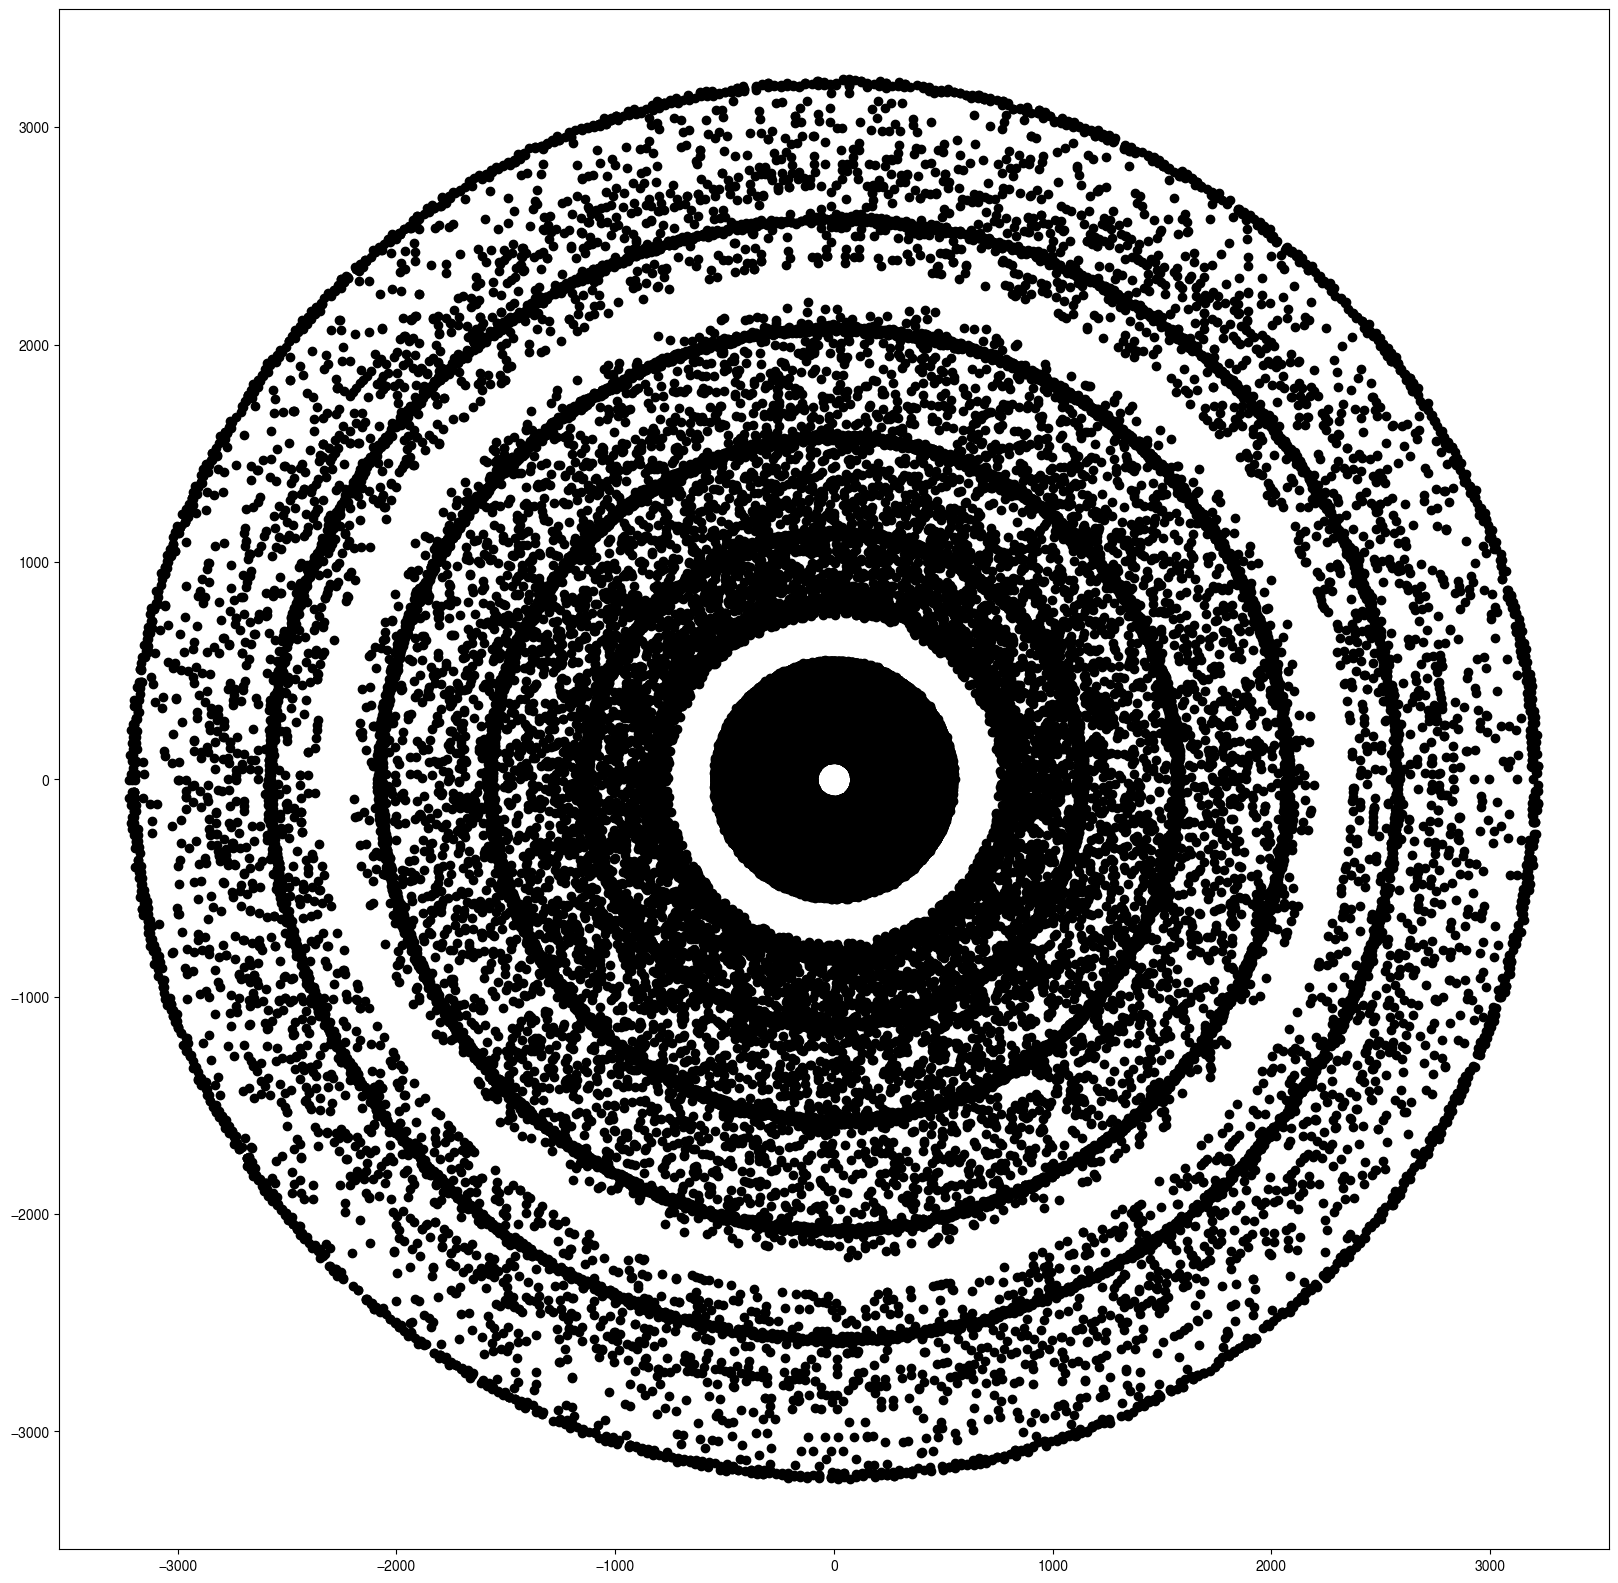

In [ ]:
x = model.trainset[0].r*np.cos(model.trainset[0].hit_id)*np.pi*1000.
y = model.trainset[0].r*np.sin(model.trainset[0].hit_id)*np.pi*1000.

plt.figure(figsize=(20,20))
edges = model.trainset[0].edge_index.numpy()
labels = model.trainset[0].y
plt.scatter(x, y, c='k')
preds = model(data).int().detach().numpy()



for j in range(len(labels)):

	# False negatives
	#if preds[j] < cut and labels[j].item() > cut:
	#	plt.plot([x[edges[0,j]], x[edges[1,j]]],
	#				[y[edges[0,j]], y[edges[1,j]]],
	#				'--', c='b')

	# False positives
	#if preds[j] > cut and labels[j].item() < cut:
	#	plt.plot([x[edges[0,j]], x[edges[1,j]]],
	#				[y[edges[0,j]], y[edges[1,j]]],
	#				'-', c='r', alpha=preds[j])

	# True positives
	if preds[j] > cut and labels[j].item() > cut:
		plt.plot([x[edges[0,j]], x[edges[1,j]]],
					[y[edges[0,j]], y[edges[1,j]]],
					'-', c='k', alpha=preds[j])
			
	# True negatives
	if preds[j] < cut and labels[j].item() < cut:
		plt.plot([x[edges[0,j]], x[edges[1,j]]],
					[y[edges[0,j]], y[edges[1,j]]],
					'-', c='k', alpha=preds[j])